In [27]:
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error

import yfinance as yf
import plotly.graph_objs as go
from finta import TA
import holoviews as hv


In [28]:
# Create a function to pull in data using Yahoo finance API
def asset_df(*x):
    
    data = yf.download(tickers=[*x], period = '90d', interval = '1d')
    df = data['Close'].dropna()
    return df

In [29]:
# Dow = ^DJI
# SP500 = ^GSPC
# 30-Year TSY = ^TYX
# Crypto pairs 'CRYPTOTICKER-USD'
# Gold 'GC=F'
# Oil 'CL=F'

df = asset_df('BTC-USD','ETH-USD','^DJI','GC=F','CL=F')
df

[*********************100%***********************]  5 of 5 completed


,BTC-USD,CL=F,ETH-USD,GC=F,^DJI
Date,,,,,
2021-09-20,42843.800781,70.290001,2958.993408,1761.800049,33970.468750
2021-09-21,40693.675781,70.559998,2764.431152,1776.000000,33919.839844
2021-09-22,43574.507812,72.230003,3077.867920,1776.699951,34258.320312
2021-09-23,44895.097656,73.300003,3155.523682,1747.699951,34764.820312
2021-09-24,42839.750000,73.980003,2931.669189,1749.699951,34798.000000
...,...,...,...,...,...
2021-12-13,46737.480469,71.290001,3784.226807,1786.300049,35650.949219
2021-12-14,46612.632812,70.730003,3745.440430,1770.400024,35544.179688
2021-12-15,48896.722656,70.870003,4018.388672,1762.599976,35927.429688


In [30]:
# Create function to run correlation matrix on any asset
def asset_corr(df):
    pct_chg_df = df.pct_change()
    df_corr = pct_chg_df.corr()
    df_corr_plot = df_corr.hvplot.bar(rot=90, ylim = [-1,1])
    return df_corr_plot

In [31]:
# update holding 1 constant with bar graph
# keep only corr abso value above certain threshold 
asset_corr(df)

:Bars   [index,Variable]   (value)

In [47]:
# Convert df to % change for analysis
pct_chg_df = df.pct_change()
pct_chg_df = pct_chg_df.dropna()

# RF Model

In [48]:
# Define features set
# Manually Change the first arugument to whatever you want to predict
X = pct_chg_df.copy()
X.drop("BTC-USD", axis=1, inplace=True)
X.head()

,CL=F,ETH-USD,GC=F,^DJI
Date,,,,
2021-09-21,0.003841,-0.065753,0.008060,-0.001490
2021-09-22,0.023668,0.113382,0.000394,0.009979
2021-09-23,0.014814,0.025230,-0.016322,0.014785
2021-09-24,0.009277,-0.070941,0.001144,0.000954
2021-09-27,0.019870,0.000842,0.000171,0.002051


In [49]:
# Define target vector
y = pct_chg_df["BTC-USD"].values.reshape(-1, 1)
y[:5]

array([[-0.05018521],
       [ 0.07079311],
       [ 0.03030648],
       [-0.04578112],
       [-0.01409951]])

In [50]:
# # Create function for RF Model

# def rf_rscore(X,y):
    
#     #split data into training and testing data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
#     #initiate, fit, and train rf_model
#     #estimators - check rmse...increase estimators as long as RMSE improves
#     rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
#     rf_model = rf_model.fit(X_train, y_train)
    
#     #make predictions for target using X_test
#     predictions = rf_model.predict(X_test)
    
#     return rf_model.score(X_test, y_test)

In [51]:

#split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    #initiate, fit, and train rf_model
    #estimators - check rmse...increase estimators as long as RMSE improves
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model = rf_model.fit(X_train, y_train)
    
    #make predictions for target using X_test
predictions = rf_model.predict(X_train)
predictions





array([-0.04668141,  0.01284403,  0.07124838,  0.0753242 ,  0.01880449,
       -0.00753491,  0.00332358, -0.01969556, -0.0065462 , -0.02487865,
        0.0145133 , -0.00150387,  0.00472882,  0.03733705, -0.012637  ,
       -0.00185435, -0.01898432,  0.04821685, -0.03286201,  0.03485287,
        0.03027793,  0.04805825, -0.02212961, -0.05474144, -0.03177825,
        0.01659553, -0.02019465, -0.04159373,  0.06963874,  0.02963077,
        0.03634843,  0.0024922 , -0.01201296, -0.01160201, -0.02211036,
       -0.04753853,  0.04655336, -0.03942953,  0.06001513, -0.01163682,
        0.03039021,  0.04348245, -0.05253921,  0.03999202,  0.02669828,
       -0.01477817, -0.01403134])

In [68]:
# OUT SAMPLE RMSE

out_sample_results = pd.DataFrame(y_test, columns=['actual'])

# Add a column of "in-sample" predictions to that DataFrame:  
out_sample_results["out-sample Predictions"] = rf_model.predict(X_test)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
out_sample_mse = mean_squared_error(
    out_sample_results["actual"],
    out_sample_results["out-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
out_sample_rmse = np.sqrt(out_sample_mse)
out_sample_rmse

0.03051527919283354

<AxesSubplot:>

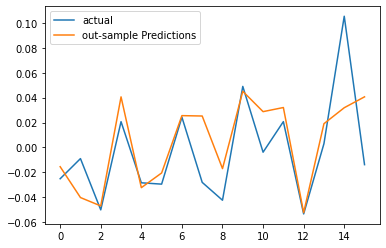

In [73]:
out_sample_results.plot()

In [66]:
# IN SAMPLE RMSE

in_sample_results = pd.DataFrame(y_train, columns=['actual'])

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = rf_model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["actual"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
in_sample_rmse

0.010584569972942034

In [69]:
# # List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.7353226478037722, 'ETH-USD'),
 (0.11897593241387466, '^DJI'),
 (0.09108827195292091, 'CL=F'),
 (0.054613147829432315, 'GC=F')]

In [94]:
for x in importances_sorted:
    importances_print = print(f'{round(x[0],2)*100}% {x[1]}')

74.0% ETH-USD
12.0% ^DJI
9.0% CL=F
5.0% GC=F


In [91]:
importances_print

# Algo Trader

In [40]:
# def boll_bands(ticker):
#     # Create a new clean copy of the signals_df DataFrame
#     bb_signals_df = yf.download(tickers = ticker, period = '90d', interval = '1d')
    
#     # Determine the Bollinger Bands for the Dataset
#     bbands_df = TA.BBANDS(bb_signals_df)
    
#     # Concatenate the Bollinger Bands to the DataFrame
#     bb_signals_df = pd.concat([bb_signals_df, bbands_df], axis=1)
    
#     # Visualize close price for the investment
#     security_close = bb_signals_df[["Close"]].hvplot(
#         line_color='lightgray',
#         ylabel='Price in $',
#         width=1000,
#         height=400
#     )

#     bb_upper = bb_signals_df[["BB_UPPER"]].hvplot(
#         line_color='purple',
#         ylabel='Price in $',
#         width=1000,
#         height=400
#     )


#     bb_middle = bb_signals_df[["BB_MIDDLE"]].hvplot(
#         line_color='orange',
#         ylabel='Price in $',
#         width=1000,
#         height=400
#     )

#     bb_lower = bb_signals_df[["BB_LOWER"]].hvplot(
#         line_color='blue',
#         ylabel='Price in $',
#         width=1000,
#         height=400
#     )

#     # Overlay plots
#     bbands_plot = security_close * bb_upper * bb_middle * bb_lower
#     return bbands_plot

In [41]:
# boll_bands('ETH-USD')

# Create Moving Averages

In [313]:
# # Create a signals_df DataFrame that is a copy of the data Dataframe
# signals_df = yf.download(tickers = 'BTC-USD', period = '250d', interval = '1d')

# # Set the short window and long windows
# short_window = 25
# long_window = 100

# # Add the SMA technical indicators for the short and long windows
# signals_df["Short"] = TA.SMA(signals_df, short_window)
# signals_df["Long"] = TA.SMA(signals_df, long_window)

# # Determine the Bollinger Bands for the Dataset
# bbands_df = TA.BBANDS(signals_df)
    
# # Concatenate the Bollinger Bands to the DataFrame
# all_signals_df = pd.concat([signals_df, bbands_df], axis=1)

# # Review the DataFrame
# all_signals_df.head()

In [314]:
# # Set the Signal column
# all_signals_df["Signal"] = 0.0

# # Generate the trading signal 1 or 0,
# # where 1 is when the Short window is greater than (or crosses over) the Long Window
# # where 0 is when the Short window is under the Long window
# all_signals_df["Signal"][short_window:] = np.where(
#     all_signals_df["Short"][short_window:] > all_signals_df["Long"][short_window:], 1.0, 0.0)

# # Calculate the points in time at which a position should be taken, 1 or -1
# all_signals_df["Entry/Exit"] = all_signals_df["Signal"].diff()

# # Review the DataFrame
# all_signals_df.head()

In [315]:
# # Visualize entry position relative to close price
# entry = all_signals_df[all_signals_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
#     color='purple',
#     marker='^',
#     size=200,
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize exit position relative to close price
# exit = all_signals_df[all_signals_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
#     color='orange',
#     marker='v',
#     size=200,
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize close price for the investment
# security_close = all_signals_df[["Close"]].hvplot(
#     line_color='lightgray',
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize moving averages
# moving_avgs = all_signals_df[["Short", "Long"]].hvplot(
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize close price for the investment
# security_close = all_signals_df[["Close"]].hvplot(
#     line_color='lightgray',
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# bb_upper = all_signals_df[["BB_UPPER"]].hvplot(
#     line_color='purple',
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )


# bb_middle = all_signals_df[["BB_MIDDLE"]].hvplot(
#     line_color='orange',
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# bb_lower = all_signals_df[["BB_LOWER"]].hvplot(
#     line_color='blue',
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )
    
# # Overlay plots
# entry_exit_plot = security_close * moving_avgs * entry * exit * bb_upper * bb_middle * bb_lower
# entry_exit_plot

# Create function for algo trader that works on any ticker

In [316]:
def algo_trader(ticker):
    
    # Create a signals_df DataFrame that is a copy of the data Dataframe
    signals_df = yf.download(tickers = ticker, period = '250d', interval = '1d')

    # Set the short window and long windows
    short_window = 25
    long_window = 100

    # Add the SMA technical indicators for the short and long windows
    signals_df["Short"] = TA.SMA(signals_df, short_window)
    signals_df["Long"] = TA.SMA(signals_df, long_window)

    # Determine the Bollinger Bands for the Dataset
    bbands_df = TA.BBANDS(signals_df)

    # Concatenate the Bollinger Bands to the DataFrame
    all_signals_df = pd.concat([signals_df, bbands_df], axis=1)

    # Set the Signal column
    all_signals_df["Signal"] = 0.0

    # Generate the trading signal 1 or 0,
    # where 1 is when the Short window is greater than (or crosses over) the Long Window
    # where 0 is when the Short window is under the Long window
    all_signals_df["Signal"][short_window:] = np.where(
        all_signals_df["Short"][short_window:] > all_signals_df["Long"][short_window:], 1.0, 0.0)

    # Calculate the points in time at which a position should be taken, 1 or -1
    all_signals_df["Entry/Exit"] = all_signals_df["Signal"].diff()

    # Visualize entry position relative to close price
    entry = all_signals_df[all_signals_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
        color='green',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize exit position relative to close price
    exit = all_signals_df[all_signals_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
        color='red',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize close price for the investment
    security_close = all_signals_df[["Close"]].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize moving averages
    moving_avgs = all_signals_df[["Short", "Long"]].hvplot(
        ylabel='Price in $',
        width=1000,
        height=400
    )


    # Visualize Bollinger Bands
    bb_upper = all_signals_df[["BB_UPPER"]].hvplot(
        line_color='purple',
        ylabel='Price in $',
        width=1000,
        height=400
    )


    bb_middle = all_signals_df[["BB_MIDDLE"]].hvplot(
        line_color='orange',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    bb_lower = all_signals_df[["BB_LOWER"]].hvplot(
        line_color='blue',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Overlay plots
    entry_exit_plot = security_close * moving_avgs * entry * exit * bb_upper * bb_middle * bb_lower
    return entry_exit_plot

In [317]:
algo_trader('BTC-USD')

[*********************100%***********************]  1 of 1 completed


/Users/jonyamaoka/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)
   .Curve.II         :Curve   [Date]   (BB_UPPER)
   .Curve.III        :Curve   [Date]   (BB_MIDDLE)
   .Curve.IV         :Curve   [Date]   (BB_LOWER)

# Work in progress

In [242]:
# Add the SMA technical indicators for the short and long windows
rsi = TA.RSI(signals_df,period=14)


In [243]:
signals_df

,Open,High,Low,Close,Adj Close,Volume,Short,Long
Date,,,,,,,,
2021-04-07,58186.507812,58731.144531,55604.023438,56048.937500,56048.937500,75645303584,NaN,NaN
2021-04-08,56099.914062,58338.738281,55879.085938,58323.953125,58323.953125,53053855641,NaN,NaN
2021-04-09,58326.562500,58937.046875,57807.863281,58245.003906,58245.003906,46655208546,NaN,NaN
2021-04-10,58253.777344,61276.664062,58038.707031,59793.234375,59793.234375,58238470525,NaN,NaN
2021-04-11,59846.230469,60790.554688,59289.796875,60204.964844,60204.964844,46280252580,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-08,50667.648438,51171.375000,48765.988281,50504.796875,50504.796875,28479699446,56342.602656,54569.385313
2021-12-09,50450.082031,50797.164062,47358.351562,47672.121094,47672.121094,29603577251,55630.813906,54574.439648
2021-12-10,47642.144531,50015.253906,47023.699219,47243.304688,47243.304688,30966005122,54978.231250,54558.402422


In [244]:
# Visualize RSI for the investment
rsi_plot = rsi.hvplot(
    line_color='lightgray',
    ylabel='RSI',
    width=1000,
    height=400,
    ylim=[0,100]

)

final_rsi_plot = rsi_plot * hv.HLine(70).opts(color='red') *hv.HLine(30).opts(color='lightgreen')


In [245]:
final_rsi_plot

:Overlay
   .Curve.A_14_period_RSI :Curve   [Date]   (14 period RSI)
   .HLine.I               :HLine   [x,y]
   .HLine.II              :HLine   [x,y]